In [1]:
import braingeneers
from braingeneers import analysis
import braingeneers.data.datasets_electrophysiology as ephys
import matplotlib.pyplot as plt
import numpy as np
# import braingeneers.analysis.plot as bviz
import h5py
import braingeneers.utils.smart_open_braingeneers as smart_open
fs = 20000.0 


In [2]:
# path = "/home/kang/disk/Connectoid/chip11350/Trace_20220503_12_25_42v_chip11350_curated.zip"
# raw_data_path = "/home/kang/disk/Connectoid/chip11350/Trace_20220503_12_25_42v_chip11350.raw.h5"
path = "/home/kang/disk/Opto/20221019_ucsf/hc9.19_chp-16849_plated-10.19.22_rec10.19.22_curated.zip"
raw_data_path = "/home/kang/disk/Opto/20221019_ucsf/hc9.19_chp-16849_plated-10.19.22_rec10.19.22.raw.h5"
rec_chan = ephys.load_channels_maxwell(raw_data_path)
print(rec_chan.shape)
spike_data = analysis.read_phy_files(path)
neuron_data = spike_data.neuron_data[0]
spike_times = spike_data.train
# N = spike_data.N
print(len(spike_times))
print(spike_data.length) 


(984,)
38
1269869.3


In [3]:
def functional_pairs(sttc_thr, sttc, chn_pos, lat_thr):
    paired_direction = []
    for i in range(len(spike_times) - 1):  # i, j are the indices to spike_times
        for j in range(i + 1, len(spike_times)):
            if sttc[i][j] >= sttc_thr:
                lat = analysis.latency(list(spike_times[i]), list(spike_times[j]), threshold=lat_thr)
                pos_count = len(list(filter(lambda x: (x >= 0), lat)))
                if abs(pos_count - (len(lat) - pos_count)) > 0.8 * len(lat):
                    if np.mean(lat) > 0:
                        paired_direction.append(
                            [i, j, chn_pos[i], chn_pos[j], sttc[i][j],
                             np.mean(lat)])  # signal goes from chn_1 to chn_2
                    else:
                        paired_direction.append([j, i, chn_pos[j], chn_pos[i], sttc[i][j],
                                                 abs(np.mean(lat))])
    return paired_direction

In [4]:
def plot_functional_map(spike_times, chn_pos, elec_map=None, paired_direction=[], PDMS=False, connectoid=False, s=""):
    fig, axs = plt.subplots(figsize=(16, 10), facecolor='white')
    plt.title("{} Electrode Map".format(s))
    # draw electrodes
    if elec_map is None or len(elec_map) == 0:
        elec_xy = np.asarray([(x, y) for x in np.arange(0, 3850, 17.5)
                              for y in np.arange(0, 2100, 17.5)])
        axs.scatter(elec_xy[:, 0], elec_xy[:, 1], s=0.2, color='b', alpha=0.3)
    else:
        axs.scatter(elec_map[:, 0], elec_map[:, 1], s=0.2, color='b', alpha=0.3)

    if PDMS:
        circle_1 = (750, 1350)
        circle_2 = (3100, 750)
        a_1, a_2 = (1496, 1431), (2484, 1178)
        b_1, b_2 = (1366, 922), (2354, 669)
        radius = 750
        axs.plot([a_1[0], a_2[0]], [a_1[1], a_2[1]], color='k', alpha=0.7)
        axs.plot([b_1[0], b_2[0]], [b_1[1], b_2[1]], color='k', alpha=0.7)
        cir_1 = plt.Circle(circle_1, radius, color='k', fill=False, alpha=0.7)
        cir_2 = plt.Circle(circle_2, radius, color='k', fill=False, alpha=0.7)
        axs.set_aspect('equal', adjustable='datalim')
        axs.add_patch(cir_1)
        axs.add_patch(cir_2)

    if connectoid:
        axs.axvline(x=1925, color='k', linewidth=2, alpha=0.7, linestyle="dashed")

    # take the lowest firing rate as a reference
    ref_fr_min = min([len(spike_times[i]) for i in range(len(spike_times))])
    # ref_fr = ref_fr_min if ref_fr_min > 0 else 15
    ref_fr = 20

    if len(paired_direction) == 0:
        for i in range(len(spike_times)):
            axs.scatter(chn_pos[i][0], chn_pos[i][1], s=len(spike_times[i]) / ref_fr, color='green')
            # axs.text(chn_pos[i][0], chn_pos[i][1], str(i), color="blue", fontsize=10)
    elif len(paired_direction) > 0:
        sender = set()
        receiver = set()
        for p in paired_direction:
            sender.add(p[0])
            receiver.add(p[1])
        broker = sender.intersection(receiver)
        paired = sender.union(receiver)
        for p in paired_direction:
            ## p = [i, j, chn_pos[i], chn_pos[j], sttc[i][j], np.mean(lat)]
            color1 = 'gray' if p[0] in broker else 'r'
            color2 = 'gray' if p[1] in broker else 'b'
            axs.scatter(p[2][0], p[2][1], s=len(spike_times[p[0]]) / ref_fr * 5, color=color1)
            axs.scatter(p[3][0], p[3][1], s=len(spike_times[p[1]]) / ref_fr * 5, color=color2)
            axs.plot([p[2][0], p[3][0]], [p[2][1], p[3][1]],
                     linewidth=3 * p[4], color='darkgrey', alpha=0.7)
            axs.annotate('', xytext=(p[2][0], p[2][1]), xy=((p[2][0] + p[3][0]) / 2, (p[2][1] + p[3][1]) / 2),
                         arrowprops=dict(arrowstyle="->", color='darkgrey'), size=18)
            if 2000 <= p[2][0] <= 3000 and 0 <= p[2][1] <= 2000:
                axs.text(p[2][0], p[2][1], str(p[0]), color="k", fontsize=16)
            if 2000 <= p[3][0] <= 3000 and 0 <= p[3][1] <= 2000:
                axs.text(p[3][0], p[3][1], str(p[1]), color="k", fontsize=16)
        for i in range(len(spike_times)):
            if i not in paired:
                axs.scatter(chn_pos[i][0], chn_pos[i][1], s=len(spike_times[i]) / ref_fr * 5,
                            color='green')
                if 2000 <= chn_pos[i][0] <= 3000 and 0 <= chn_pos[i][1] <= 2000:
                    axs.text(chn_pos[i][0], chn_pos[i][1], str(i), color="b", fontsize=16)

        axs.scatter(-10, -10, s=60, color='r', label='Sender')
        axs.scatter(-10, -10, s=60, color='b', label='Receiver')
        axs.scatter(-10, -10, s=60, color='gray', label='Broker')

    axs.scatter(-10, -10, s=60, color='green', label='Unit')
    axs.legend(loc="upper right", fontsize=12)

    # axs.set_xlim(0, 3850)
    # axs.set_ylim(0, 2100)
    axs.set_xlim(2000, 3000)
    axs.set_ylim(0, 2000)
    # axs.set_xticks([0, 3850])
    # axs.set_yticks([0, 2100])
    axs.xaxis.set_tick_params(labelsize=12)
    axs.yaxis.set_tick_params(labelsize=12)
    axs.set_xlabel(u"\u03bcm", fontsize=16)
    axs.set_ylabel(u"\u03bcm", fontsize=16)
    plt.gca().invert_yaxis()
    # plt.show(block=False)
    # plt.savefig("map_opto_1019_C33C4C15C16C19.png", dpi=300)
    return axs

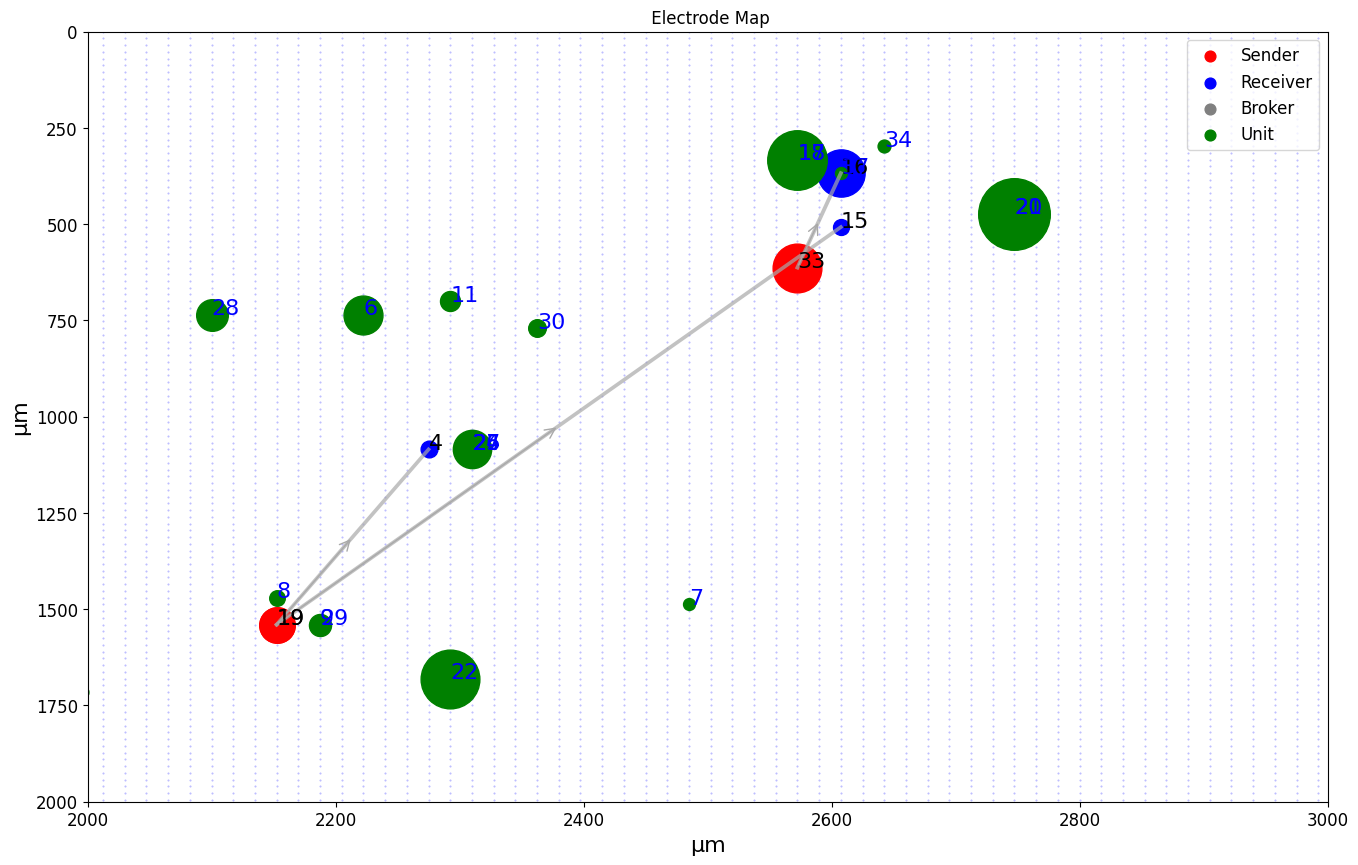

In [5]:
# map
import braingeneers.analysis.plot as bviz
sttc_thr = 0.35
lat_thr = 20
sttc = spike_data.spike_time_tilings()
chn_pos = [neuron_data[i]['position'] for i in range(spike_data.N)]
paired_directions = functional_pairs(sttc_thr, sttc, chn_pos, lat_thr)
axs_map = plot_functional_map(spike_times, chn_pos, paired_direction=paired_directions)
# axs_map.set_xlim(500, 1500)
# axs_map.set_ylim(1000, 1500)
plt.show()

In [6]:
# cluster_index = [1, 2, 3, 14, 15, 16, 19, 21, 22]
cluster_index = [33, 4, 15, 16, 19]
len(cluster_index)
# rec_period = [475, 485]
rec_period = [120, 160]

In [23]:
def plot_raster_fr(spike_times_list, fr_rate_list, rec_length, s="", extra=None):
    assert len(spike_times_list) == len(fr_rate_list), \
        "Spike times list and firing rate list are not the same length."
    if len(spike_times_list) == 2:
        n = 2
        gridspec_kw = {'height_ratios': [3, 1, 1]}
        r_color = ['blue', 'orangered']
        f_color = ['orangered', 'blue']
        label = ['right', 'left']
    else:
        n = 1
        gridspec_kw = {'height_ratios': [3, 1]}
        r_color = ['k']
        f_color = ['red']
        label = ['firing rate']
    fig, axs = plt.subplots(n + 1, 1, figsize=(12, 8), sharex=True, gridspec_kw=gridspec_kw)
    fig.set_facecolor('white')
    count = 0
    for i in range(n):
        for j in range(len(spike_times_list[i])):
            yy = [count + 1] * len(spike_times_list[i][j])
            axs[0].scatter(np.asarray(spike_times_list[i][j]) / 1000, yy, marker="|", linewidth=0.9, color=r_color[i])
            count += 1
    if extra:
        for i in extra:
            axs[0].axvspan(i[0], i[1], color='#00C0FF', alpha=0.2)  # blue led color
    axs[0].set_ylabel("Unit", fontsize=16)
    axs[0].get_xaxis().set_visible(False)
    axs[0].yaxis.set_tick_params(labelsize=16)
    axs[0].set_title("Raster of recording {}".format(s), fontsize=16)
    for i in range(n):
        xx = np.linspace(0, rec_length, len(fr_rate_list[n-i-1])) / 1000
        axs[i + 1].plot(xx, fr_rate_list[n-i-1], color=f_color[i], label=label[i])
        axs[i + 1].yaxis.set_tick_params(labelsize=16)
        axs[i + 1].set_ylabel("Hz", fontsize=16)
        axs[i + 1].get_xaxis().set_visible(False)
        axs[i + 1].legend(loc="upper right", fontsize=12)
    # xx_s = np.linspace(0, rec_length/1000, 10, dtype='int')
    # axs[n].xaxis.set_ticklabels(xx_s)
    axs[n].set_xlabel("Time (s)", fontsize=16)
    axs[n].xaxis.set_tick_params(labelsize=16)
    axs[n].get_xaxis().set_visible(True)
    for ind in cluster_index:
        axs[0].axhline(ind, color='#00C0FF', alpha=0.2, linewidth=10)
    plt.tight_layout()
    axs[1].set_xlim(rec_period)
    # plt.show(block=False)
    fig.savefig("raster_1019_120_160_cluster_labeled.png", dpi=300)
    return axs

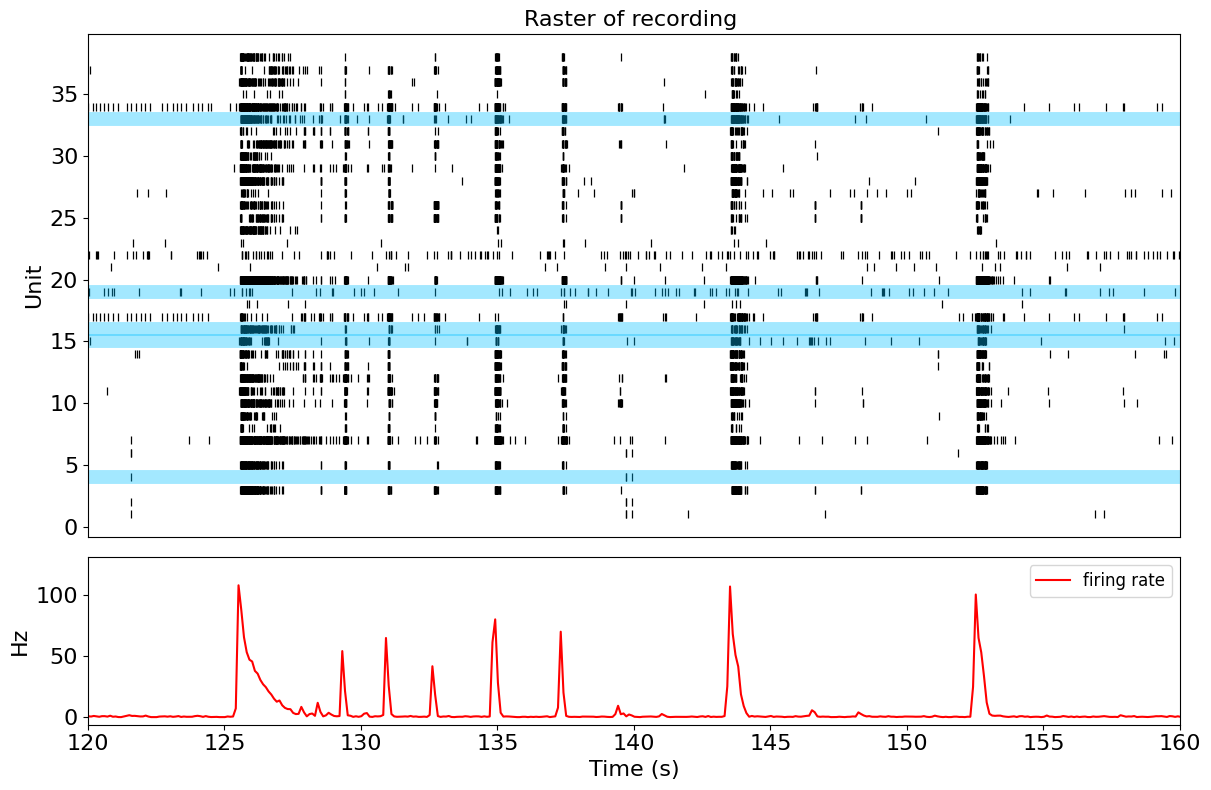

In [24]:
# spike raster for population burst

# axs = bviz.plot_raster_fr([spike_times], [analysis.moving_fr_rate(spike_times)[1]], spike_data.length)
axs = plot_raster_fr([spike_times], [analysis.moving_fr_rate(spike_times)[1]], spike_data.length)
# print(len(axs))
for ind in cluster_index:
    axs[0].axhline(ind, color='#00C0FF', alpha=0.2, linewidth=10)
axs[1].set_xlim(rec_period)
# axs[0].set_ylim([20, 125])
plt.show()
# plt.savefig("raster_1019_120_160.png", dpi=300)
# plot_raster_fr([spike_times], [analysis.moving_fr_rate(spike_times)[1]], spike_data.length)

In [8]:
center_chan = [neuron_data[index]['channel'] for index in cluster_index]
chan_pos = [neuron_data[index]['position'] for index in cluster_index]
print(center_chan, chan_pos)
raw_sig = ephys.load_raw_maxwell(raw_data_path, center_chan, rec_period)
print(raw_sig.shape)
print(raw_sig[0][:10])

[625, 666, 685, 753, 818] [(2572.5, 612.5), (2275.0, 1085.0), (2607.5, 507.5), (2607.5, 367.5), (2152.5, 1540.0)]
(5, 800000)
[3210.0679 3216.362  3210.0679 3203.7734 3203.7734 3203.7734 3210.0679
 3216.362  3210.0679 3216.362 ]


In [9]:
# bandpass the data
import scipy
def butter_bandpass_filter(data, lowcut, highcut, fs=20000, order=5):
    band = [lowcut, highcut]
    assert len(band) == 2, "Must have lowcut and highcut!"
    Wn = [e / fs * 2 for e in band]
    filter_coeff = scipy.signal.iirfilter(order, Wn, analog=False, btype='bandpass', ftype='butter', output='sos')
    filtered_traces = scipy.signal.sosfiltfilt(filter_coeff, data, axis=0)
    return filtered_traces

In [10]:
ap = [butter_bandpass_filter(raw_sig[i], 300, 6000) for i in range(len(raw_sig))]
lfp = [butter_bandpass_filter(raw_sig[i], 0.01, 100) for i in range(len(raw_sig))]
delta = [butter_bandpass_filter(lfp[i], 0.5, 4) for i in range(len(raw_sig))]
theta = [butter_bandpass_filter(lfp[i], 4, 8) for i in range(len(raw_sig))]

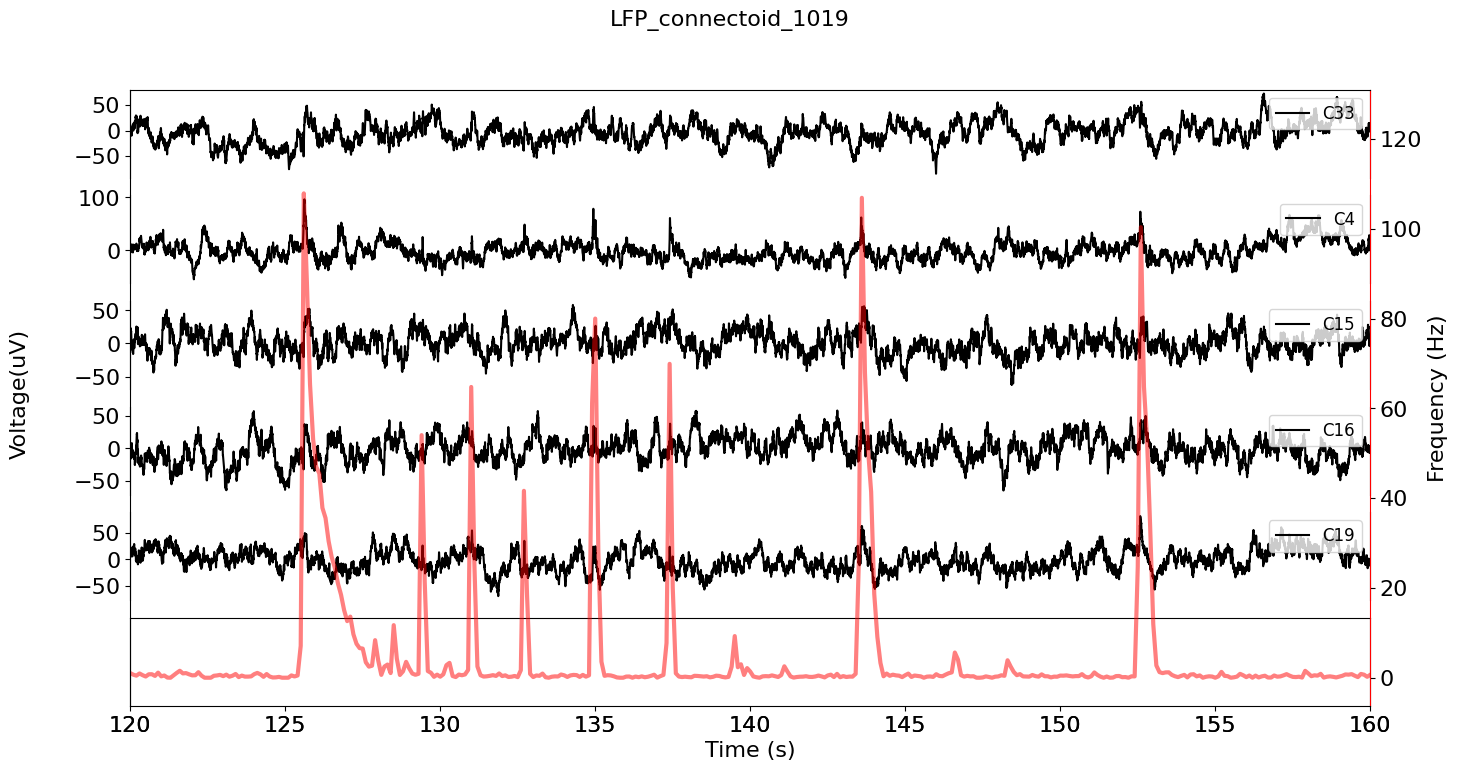

In [18]:
# all sub-bands
subbands = ['raw', 'AP', 'LFP', 'Delta', 'Theta']
signals = [raw_sig, ap, lfp, delta, theta]
signal_length = raw_sig.shape[1]
fig, axs = plt.subplots(len(cluster_index)+1, 1, figsize=(16, 8))
fig.set_facecolor('white')

xx = np.arange(0, signal_length / fs, 1/fs) + rec_period[0]
j = 2
fig.suptitle(subbands[j] + "_connectoid_1019", fontsize=16)
for i in range(len(cluster_index)):
    axs[i].plot(xx, signals[j][i], label="C" + str(cluster_index[i]), color='k')
    axs[i].legend(loc="upper right", fontsize=12)
    # axs[i].set_ylabel("Voltage (uV)", fontsize=16)
    axs[i].yaxis.set_tick_params(labelsize=16)
    axs[i].set_xticks([])
    axs[i].set_xlim(rec_period)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    # axs[i].set_xlim([776, 777])
i = len(cluster_index)
# axs[i].plot(xx, signals[j][i], label="C" + str(cluster_index[i]), color='k')
# axs[i].legend(loc="upper right", fontsize=12)
axs[i].yaxis.set_tick_params(labelsize=16)
axs[i].set_xlabel("Time (s)",  fontsize=16)
axs[i].xaxis.set_tick_params(labelsize=16)
axs[i].set_xlim(rec_period)
axs[i].spines['bottom'].set_visible(False)

# axs[i].set_xlim([776, 777])
# axs[i].set_xticks([])
axs[i].set_yticks([])
# axs[-1].set_xticks([])
# axs[-1].set_yticks([])
fig.text(0.05, 0.5, 'Voltage(uV)', va='center', rotation='vertical', fontsize=16)

# overlap firing rate with LFP
bins, rate = analysis.moving_fr_rate(spike_times)
bins = bins[1:]/1000
# st, end = np.searchsorted(bins, rec_period)
# selected
ax1 = fig.add_subplot(111, facecolor="none")
ax1.yaxis.set_label_position("right")
ax1.plot(bins, rate, color='r', alpha=0.5, linewidth=3)
ax1.set_xlim(rec_period)
# ax1.set_xlim([776, 777])
# ax1.set_ylim([0, max(rate)])
ax1.tick_params(left=False, right=True, labelleft=False, labelright=True,
                bottom=False, labelbottom=True)
ax1.set_ylabel("Frequency (Hz)",  fontsize=16)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.spines['right'].set_color('r')
plt.show()
# fig.savefig(subbands[j] + "_with_rate_opto1019_120_160_C19C16C15C4C33.png", dpi=300)
# TODO rms for each frequency band

/tmp/ipykernel_18775/1136988901.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


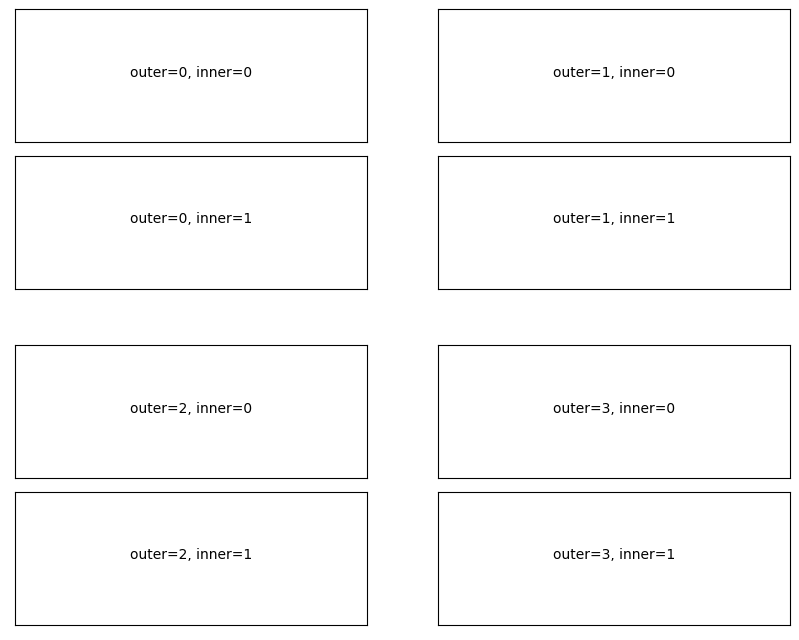

In [12]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
        t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()